In [89]:
require(dplyr)
d <- read.csv("comb-data.csv")
d$coverage_inc <- d$edges_covered - d$initial_coverage
# d$cif <- factor(d$coverage_inc, ordered=TRUE)
d <- d %>% filter(benchmark != "lcms-2017-03-21")
d <- d[c("benchmark", "fuzzer", "corpus_size",
                "initial_coverage", "ineq_reached", "ineq_unexplored",
                "indir_reached", "shared_reached", "mean_exec_ns",
                "mean_size_bytes", "coverage_inc", "eq_reached", "eq_unexplored")]
d$ineq_unex_perc <- d$ineq_unexplored / d$initial_coverage
head(d)

,benchmark,fuzzer,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,coverage_inc,eq_reached,eq_unexplored,ineq_unex_perc
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,bloaty_fuzz_target,afl,NA,6261,NA,NA,NA,NA,NA,NA,707,NA,NA,NA
2,harfbuzz-1.3.2,afl,32,4241,1332,1061,23,0,5800308,15990.03125,2395,1839,1280,0.2501768
3,libjpeg-turbo-07-2017,afl,20,1387,454,381,10,0,6971907,55.20000,637,876,661,0.2746936
4,libpcap_fuzz_both,afl,46,1441,310,238,32,0,4651877,41.30435,1199,1261,859,0.1651631
5,libpng-1.2.56,afl,38,752,203,165,7,0,4850976,94351.86842,142,676,559,0.2194149
6,libxslt_xpath,afl,139,7856,1546,1093,68,0,20656946,3660.50360,1220,4111,3176,0.1391293


Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”


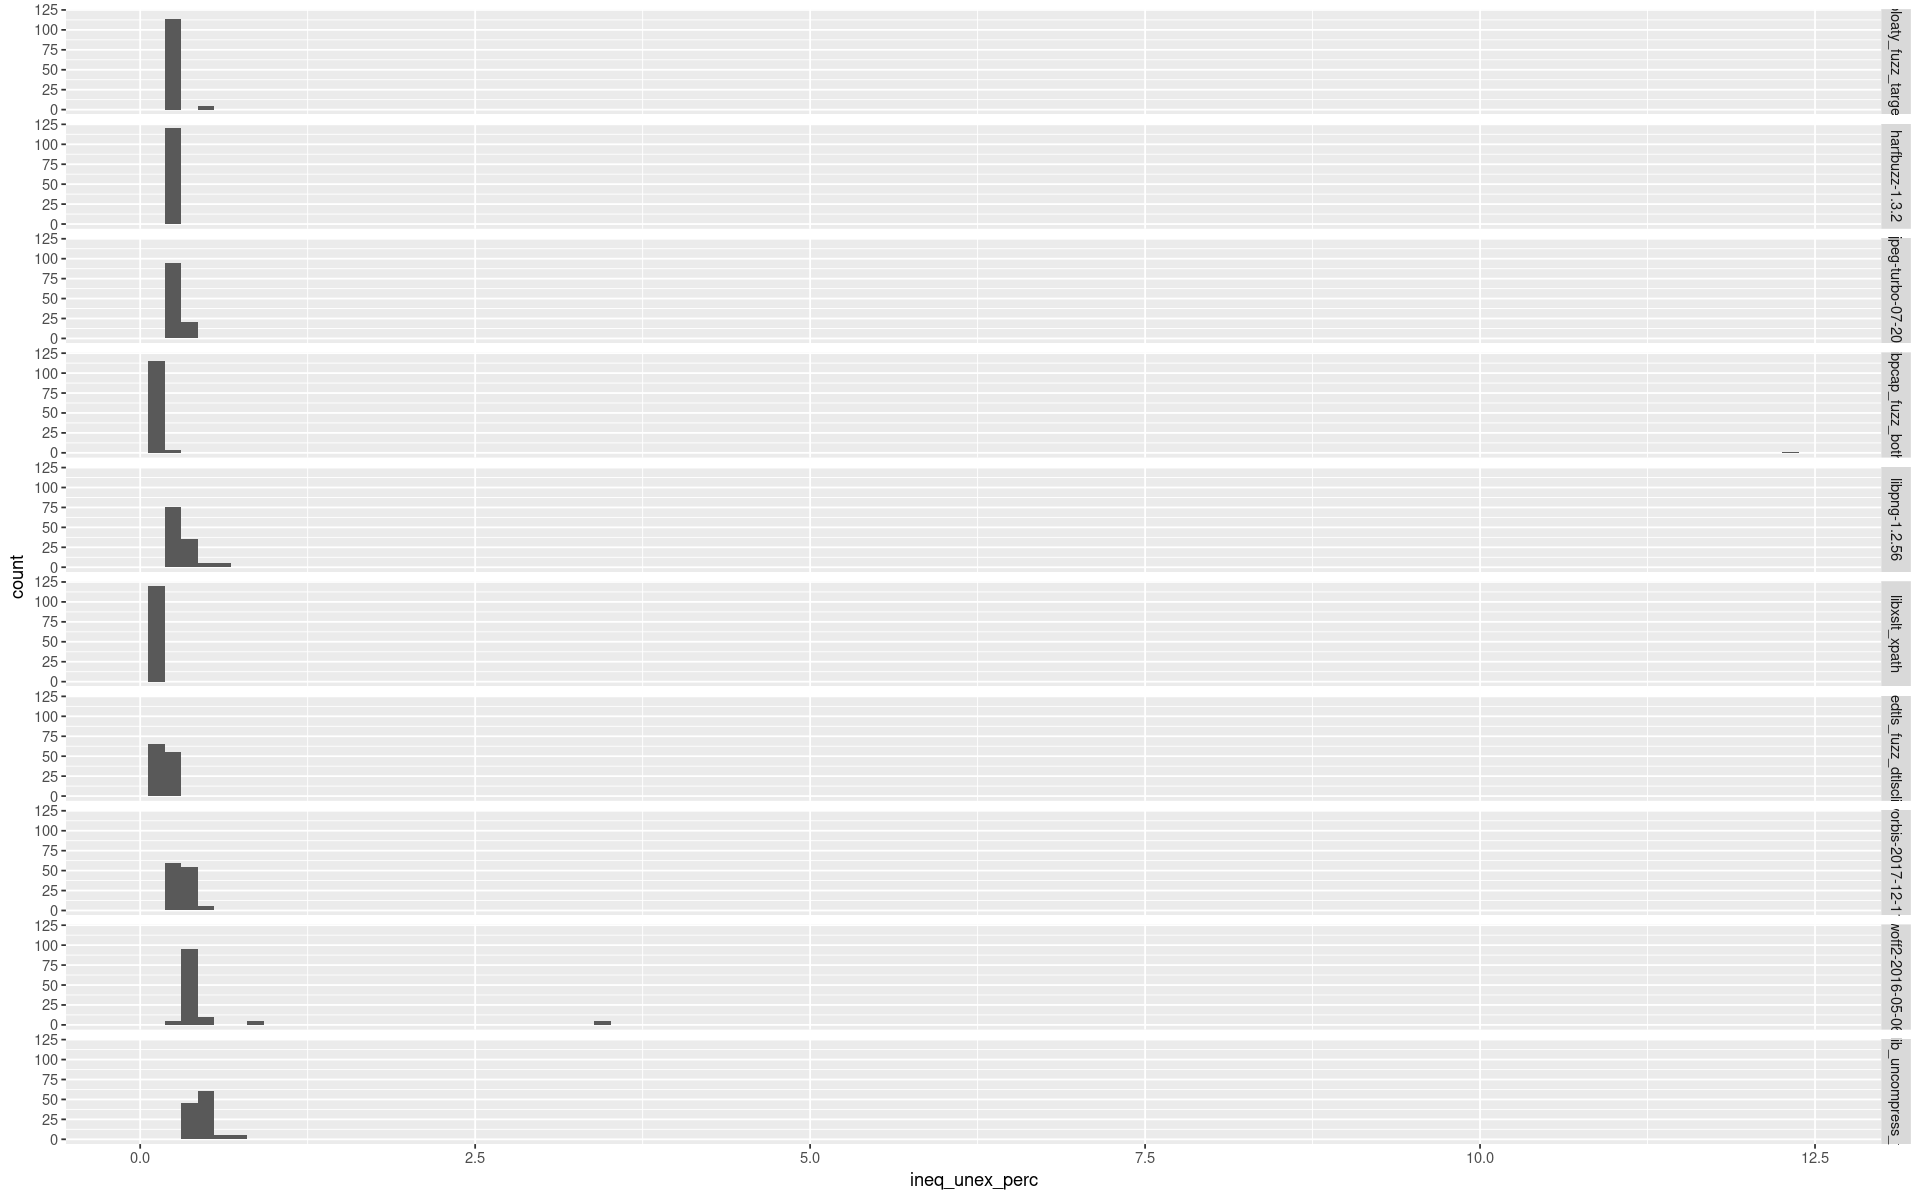

In [90]:
library("ggplot2")

ggp <- ggplot(d, aes(ineq_unex_perc)) + geom_histogram(bins=100)
ggp + facet_grid(benchmark ~ .) 

Warning message:
“Removed 5 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“

Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


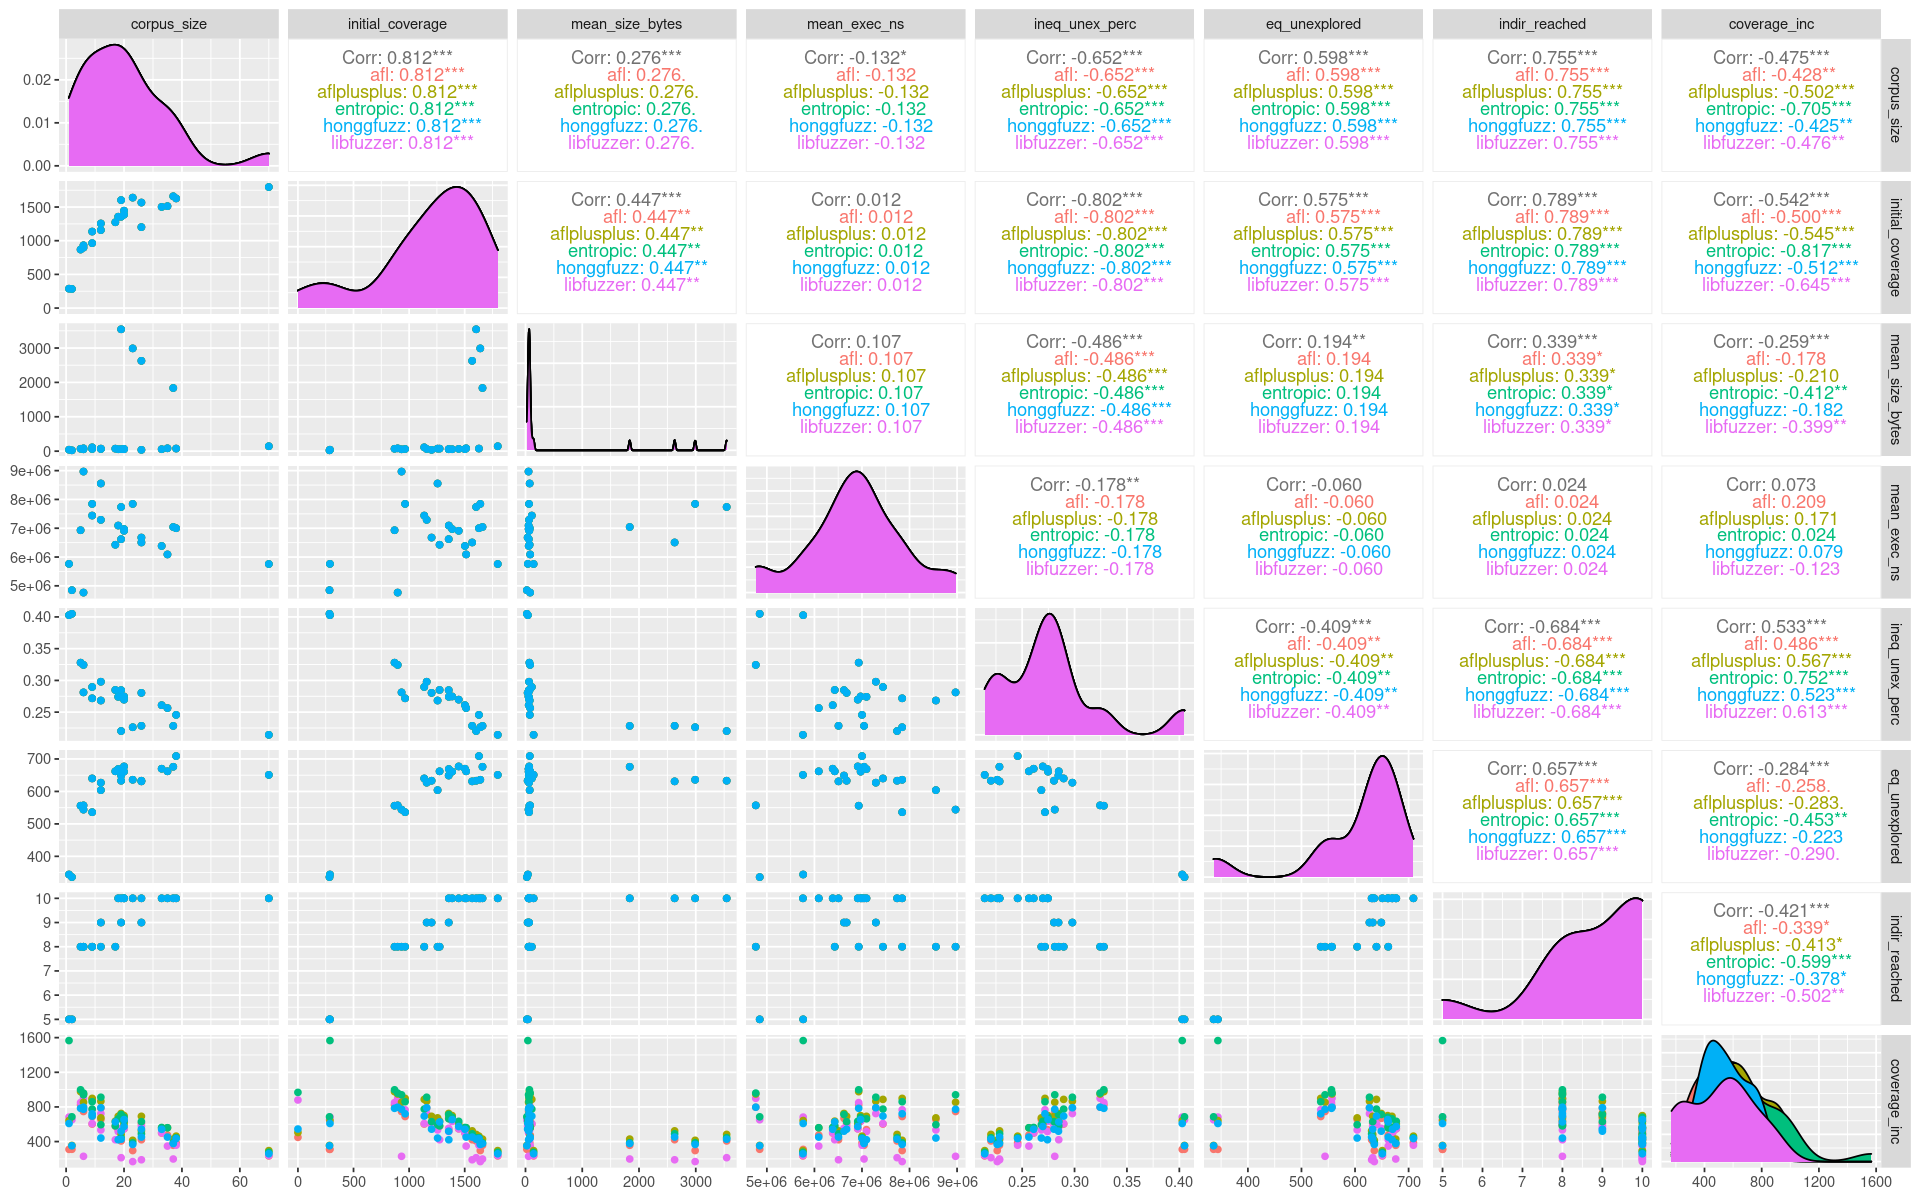

In [91]:
# install.packages("GGally")

library(GGally)
library(repr)

options(repr.plot.width=16, repr.plot.height=10)
vars = c("corpus_size", "initial_coverage", "mean_size_bytes", "mean_exec_ns", "ineq_unex_perc", "eq_unexplored", "indir_reached", "coverage_inc" )

# display a pairplot of all four columns of data
GGally::ggpairs(d %>% filter(benchmark == "libjpeg-turbo-07-2017"), columns = vars, ggplot2::aes(color = fuzzer), upper = list(continuous = wrap("cor", method = "kendall")))

In [4]:
# install.packages("tidyverse")
# install.packages("ggpubr")
# install.packages("rstatix")
# install.packages("broom")
library(tidyverse)
library(rstatix)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing non-finite values (stat_regline_equation).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


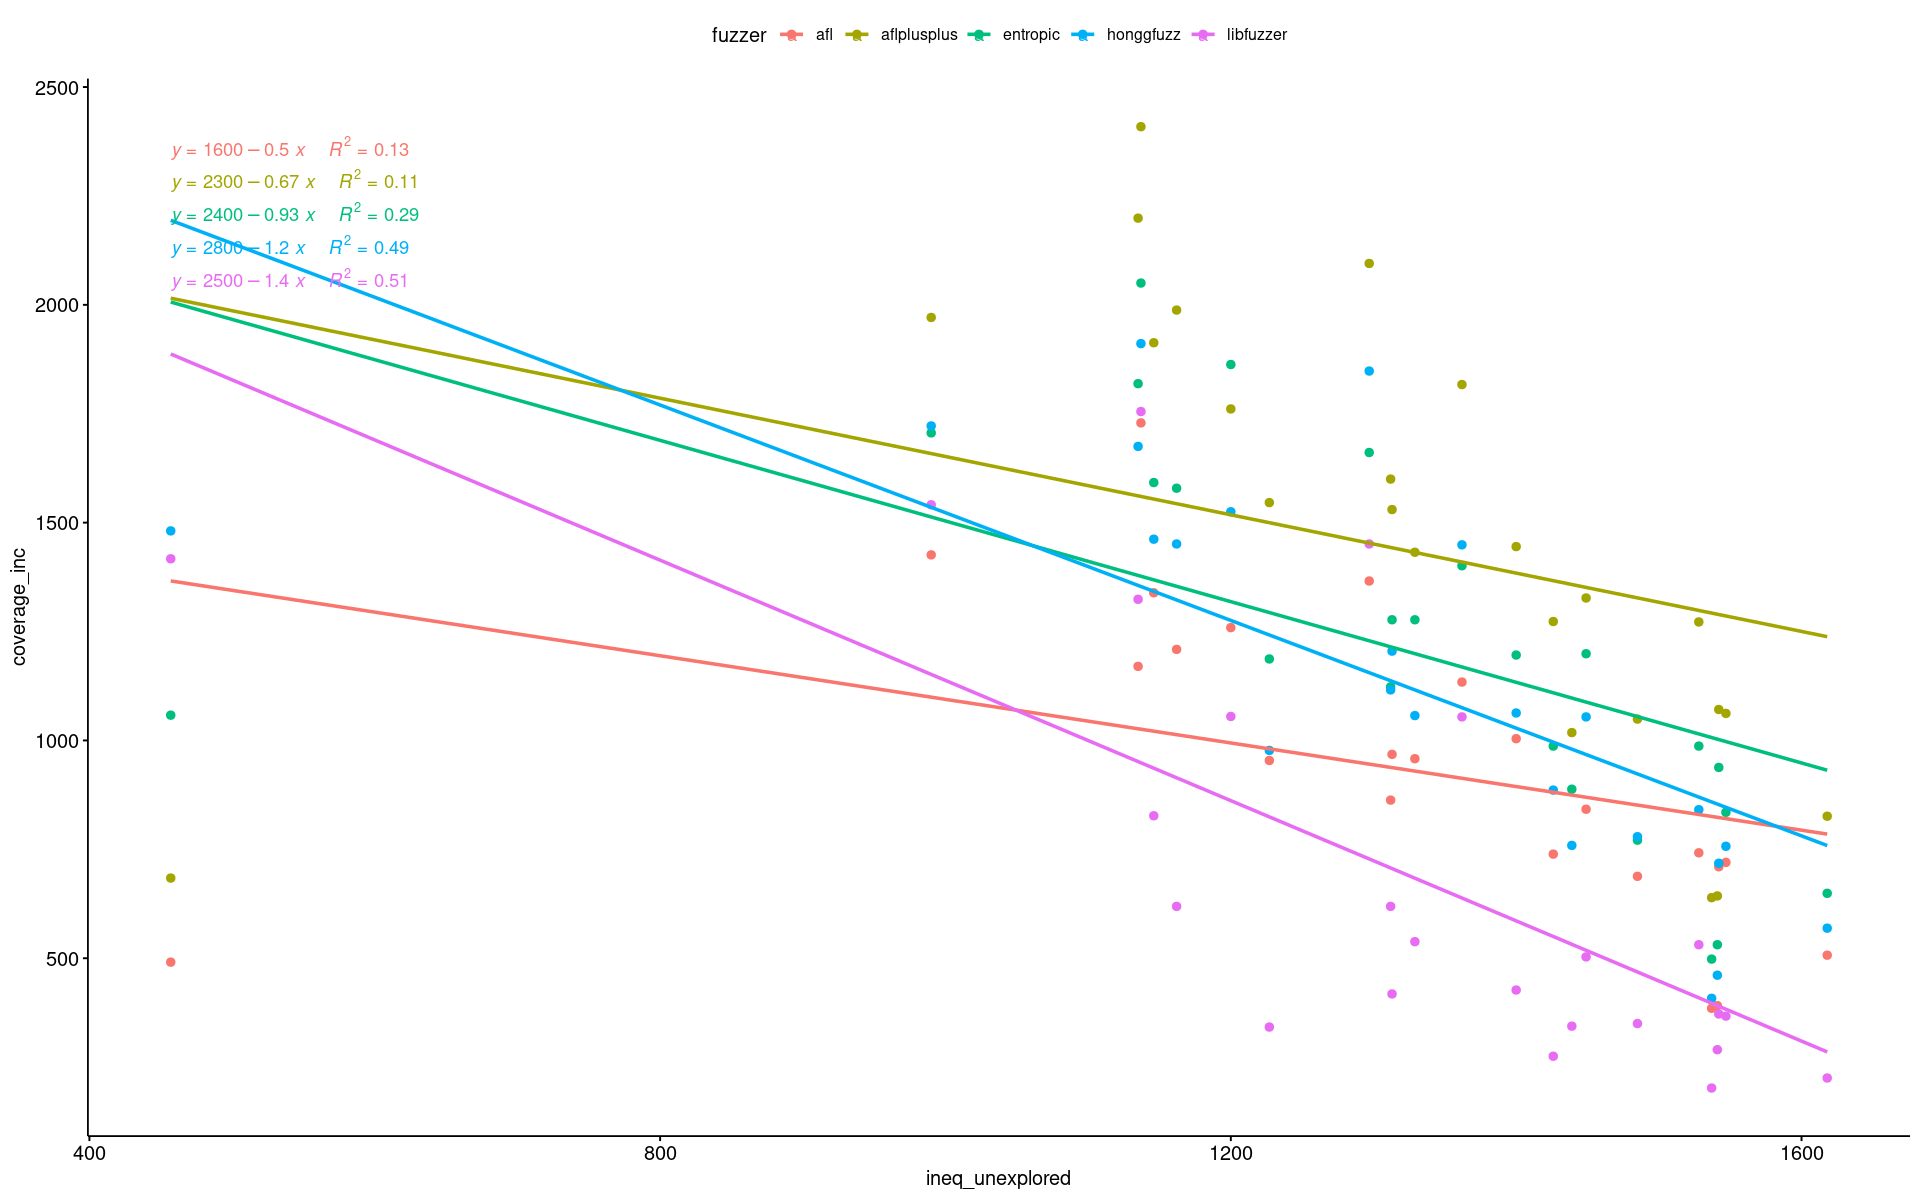

In [5]:
library(ggpubr)
# Assumption 1 (ANCOVA): Visually check for  linear relationship between covariate and output 
ggscatter(
  d[d$benchmark == "bloaty_fuzz_target",], x = "ineq_unexplored", y = "coverage_inc",
  color = "fuzzer", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)
    )


In [6]:
sample_fb <- read.csv("sample-report.csv")
require(dplyr)
max <- sample_fb %>% group_by(trial_id) %>% summarise(edges_covered = max(edges_covered))
max <- unique(left_join(max, sample_fb[c("trial_id", "benchmark", "fuzzer")], by = c("trial_id")))

norm_tests <- aggregate(formula = edges_covered ~ benchmark + fuzzer,
          data = max,
          FUN = function(x) { tryCatch({
              y <- shapiro.test(x); c(y$statistic, y$p.value)
            }, error = function(e) {
               c(0,0)
            }
          )})
norm_tests

benchmark,fuzzer,edges_covered
<chr>,<chr>,"<dbl[,2]>"
bloaty_fuzz_target,afl,"0.9018141, 1.014473e-01"
curl_curl_fuzzer_http,afl,"0.9366768, 3.424158e-01"
freetype2-2017,afl,"0.9268631, 2.448345e-01"
harfbuzz-1.3.2,afl,"0.7181742, 3.914675e-04"
jsoncpp_jsoncpp_fuzzer,afl,"0.0000000, 0.000000e+00"
lcms-2017-03-21,afl,"0.8691207, 3.275339e-02"
libjpeg-turbo-07-2017,afl,"0.4632010, 1.801132e-06"
libpcap_fuzz_both,afl,"0.3411550, 2.348710e-07"
libpng-1.2.56,afl,"0.9230509, 2.143759e-01"


Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




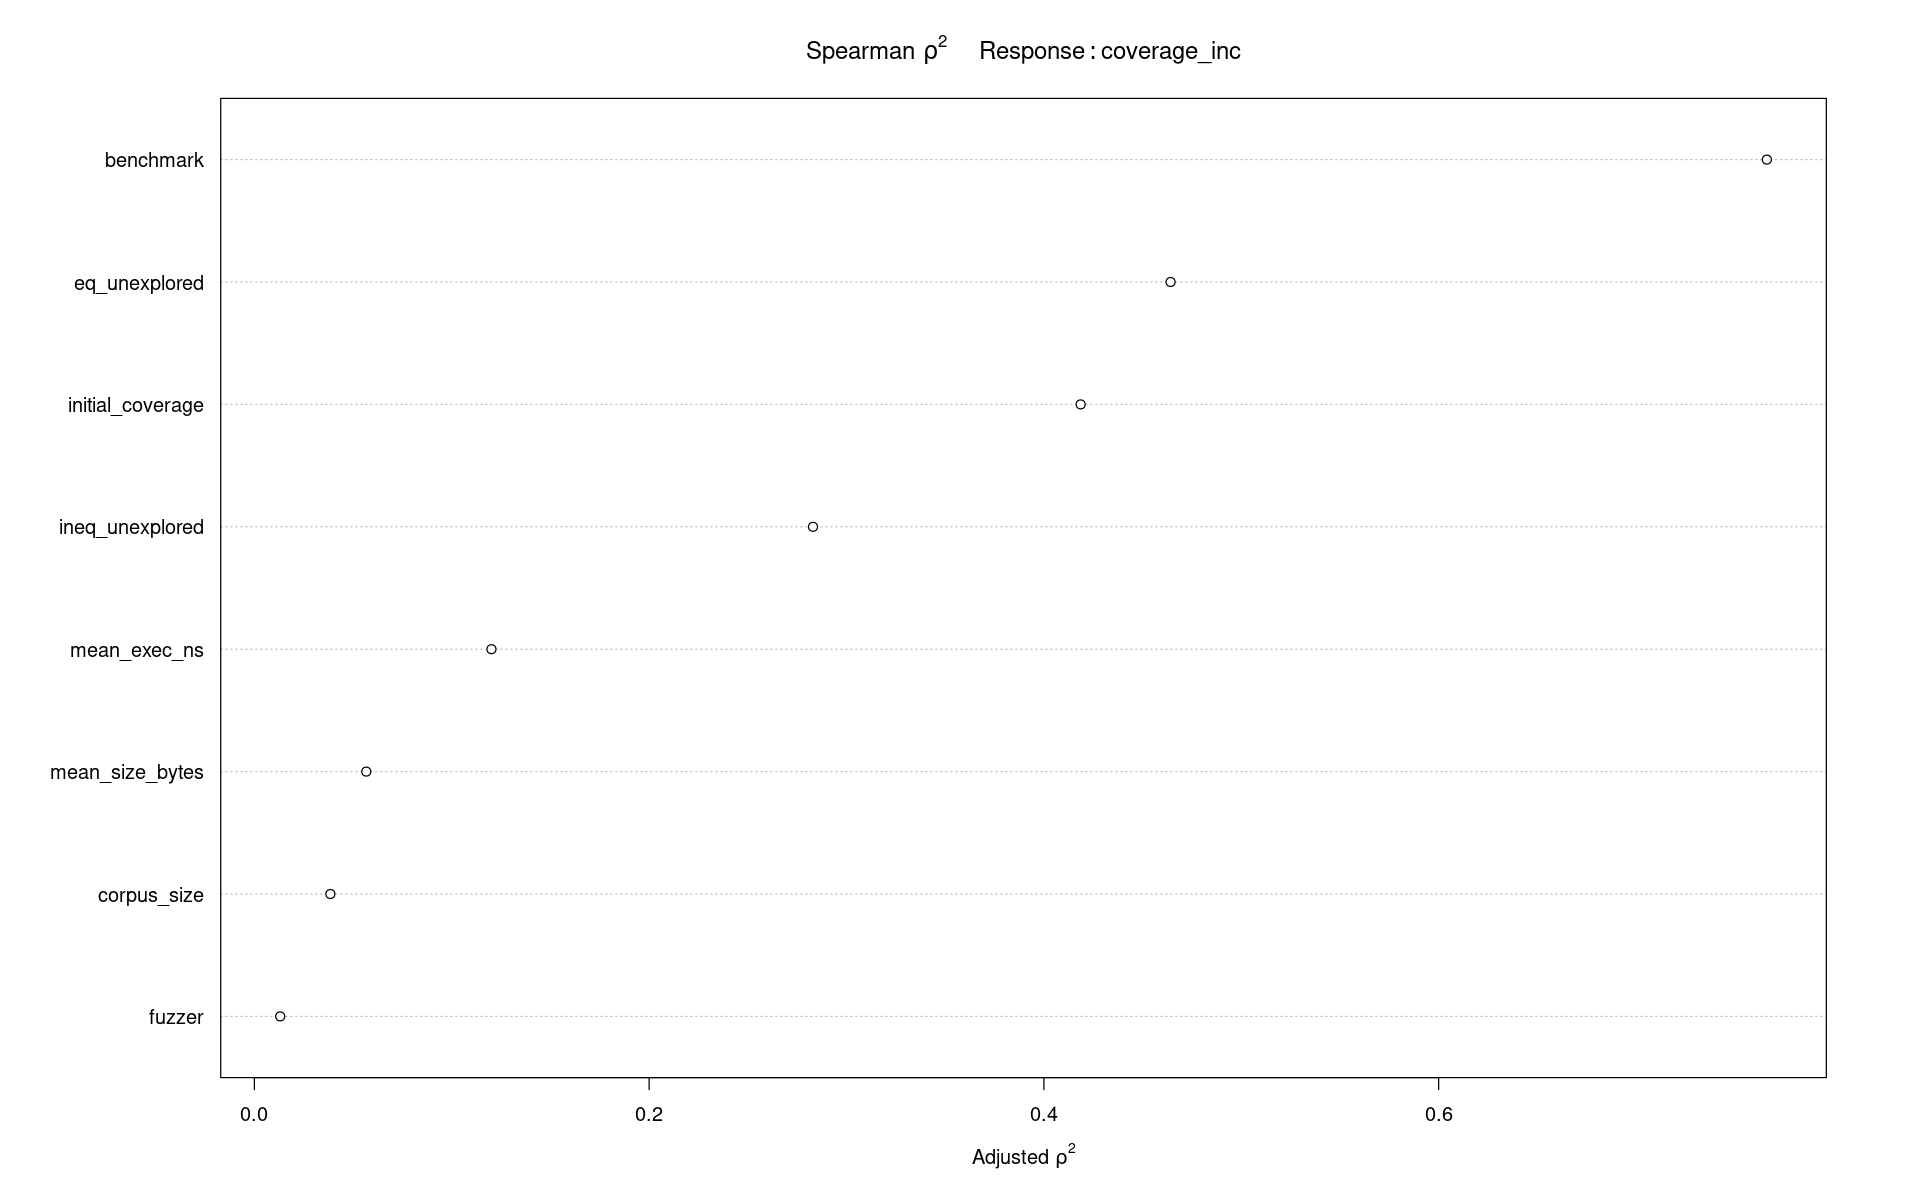

In [7]:
library("rms")

rms_d <- d

s <- spearman2(coverage_inc ~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark, data=rms_d)
plot(s)

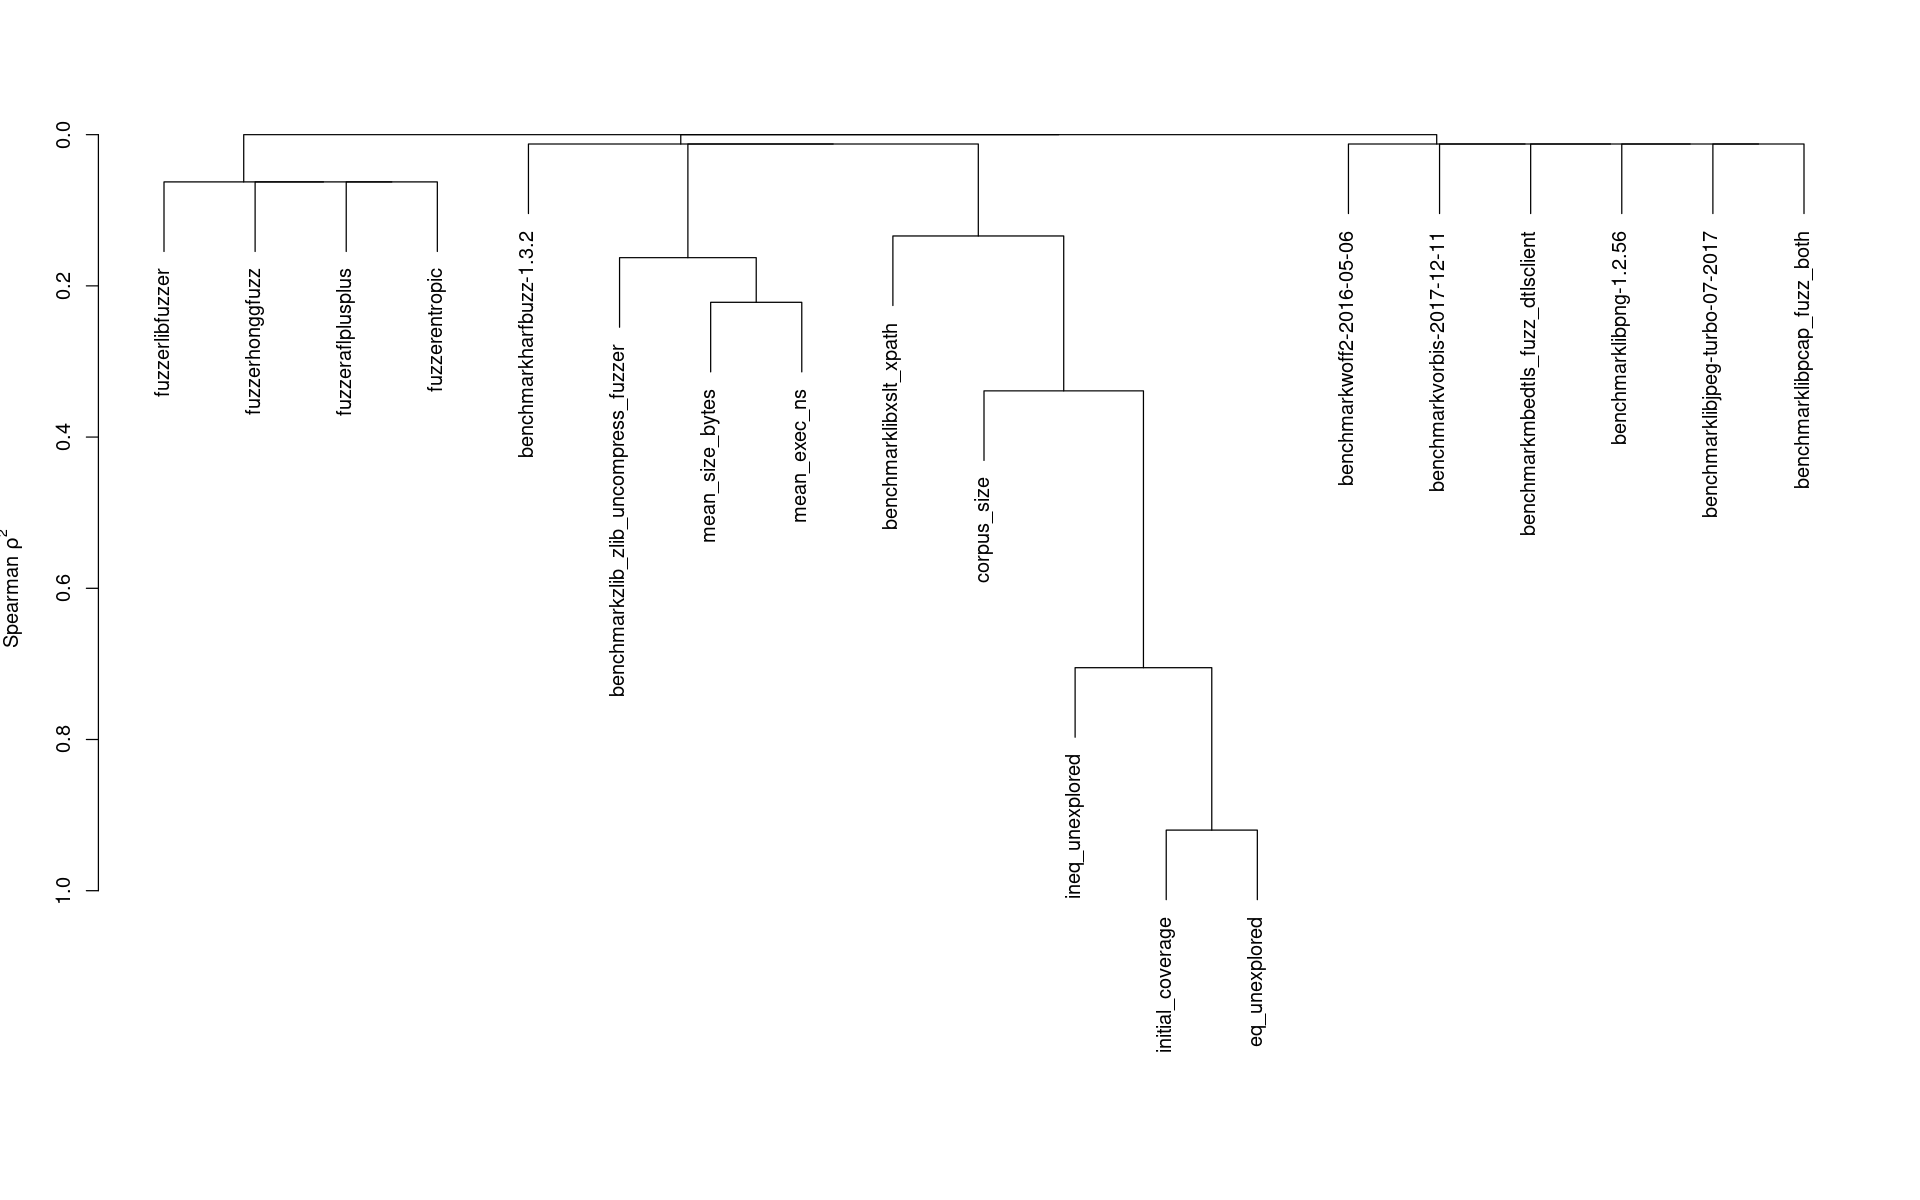

In [8]:
v <- varclus(~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark, data=rms_d)
plot(v)

In [9]:
require("rms")

model <- orm(formula = coverage_inc ~ benchmark + fuzzer + initial_coverage, data = d)
model
AIC(model)

Logistic (Proportional Odds) Ordinal Regression Model
 
 orm(formula = coverage_inc ~ benchmark + fuzzer + initial_coverage, 
     data = d)
 
                       Model Likelihood               Discrimination    Rank Discrim.    
                             Ratio Test                      Indexes          Indexes    
 Obs         1200    LR chi2    2393.87    R2                  0.864    rho     0.928    
 Distinct Y   817    d.f.            14    R2(14,1200)         0.862                     
 Median Y     519    Pr(> chi2) <0.0001    R2(14,1200)         0.862                     
 max |deriv|  0.2    Score chi2 2328.99    |Pr(Y>=median)-0.5| 0.402                     
                     Pr(> chi2) <0.0001                                                  
 
                                       Coef     S.E.   Wald Z Pr(>|Z|)
 benchmark=harfbuzz-1.3.2                3.8024 0.2581  14.73 <0.0001 
 benchmark=libjpeg-turbo-07-2017       -13.4972 0.5861 -23.03 <0.0001 
 benchmark=l

[1] 15046.86

In [133]:
require(dplyr)
require(purrr)
require(plyr)



corellation <- function(y, x) {
    t <- cor.test(y, x, method = "spearman")
  
    if (is.finite(t$p.value) && t$p.value < 0.05) {

        t$estimate
    } else {
        rv <- NA
        names(rv)[0] <- "rho"
        rv
    }
}

acc_coefs <- function(f, notused) { 
    g <- f %>% group_by(benchmark) %>%
        group_map(
            ~ c(corellation(.x$coverage_inc, .x$indir_reached), .x$benchmark[1]),
            .keep = TRUE
        ) %>% bind_rows()

    g
}

res <- d %>% group_by(fuzzer) %>%
        group_map(
            ~ acc_coefs(.x, 0) %>% add_column(fuzz = .x$fuzzer[1]),
            .keep = TRUE
        ) %>% bind_rows() 

names(res)[2] <- 'bench'
res$rho <- as.numeric(res$rho)



Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor(rank(x), rank(y)):
“the standard

Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”


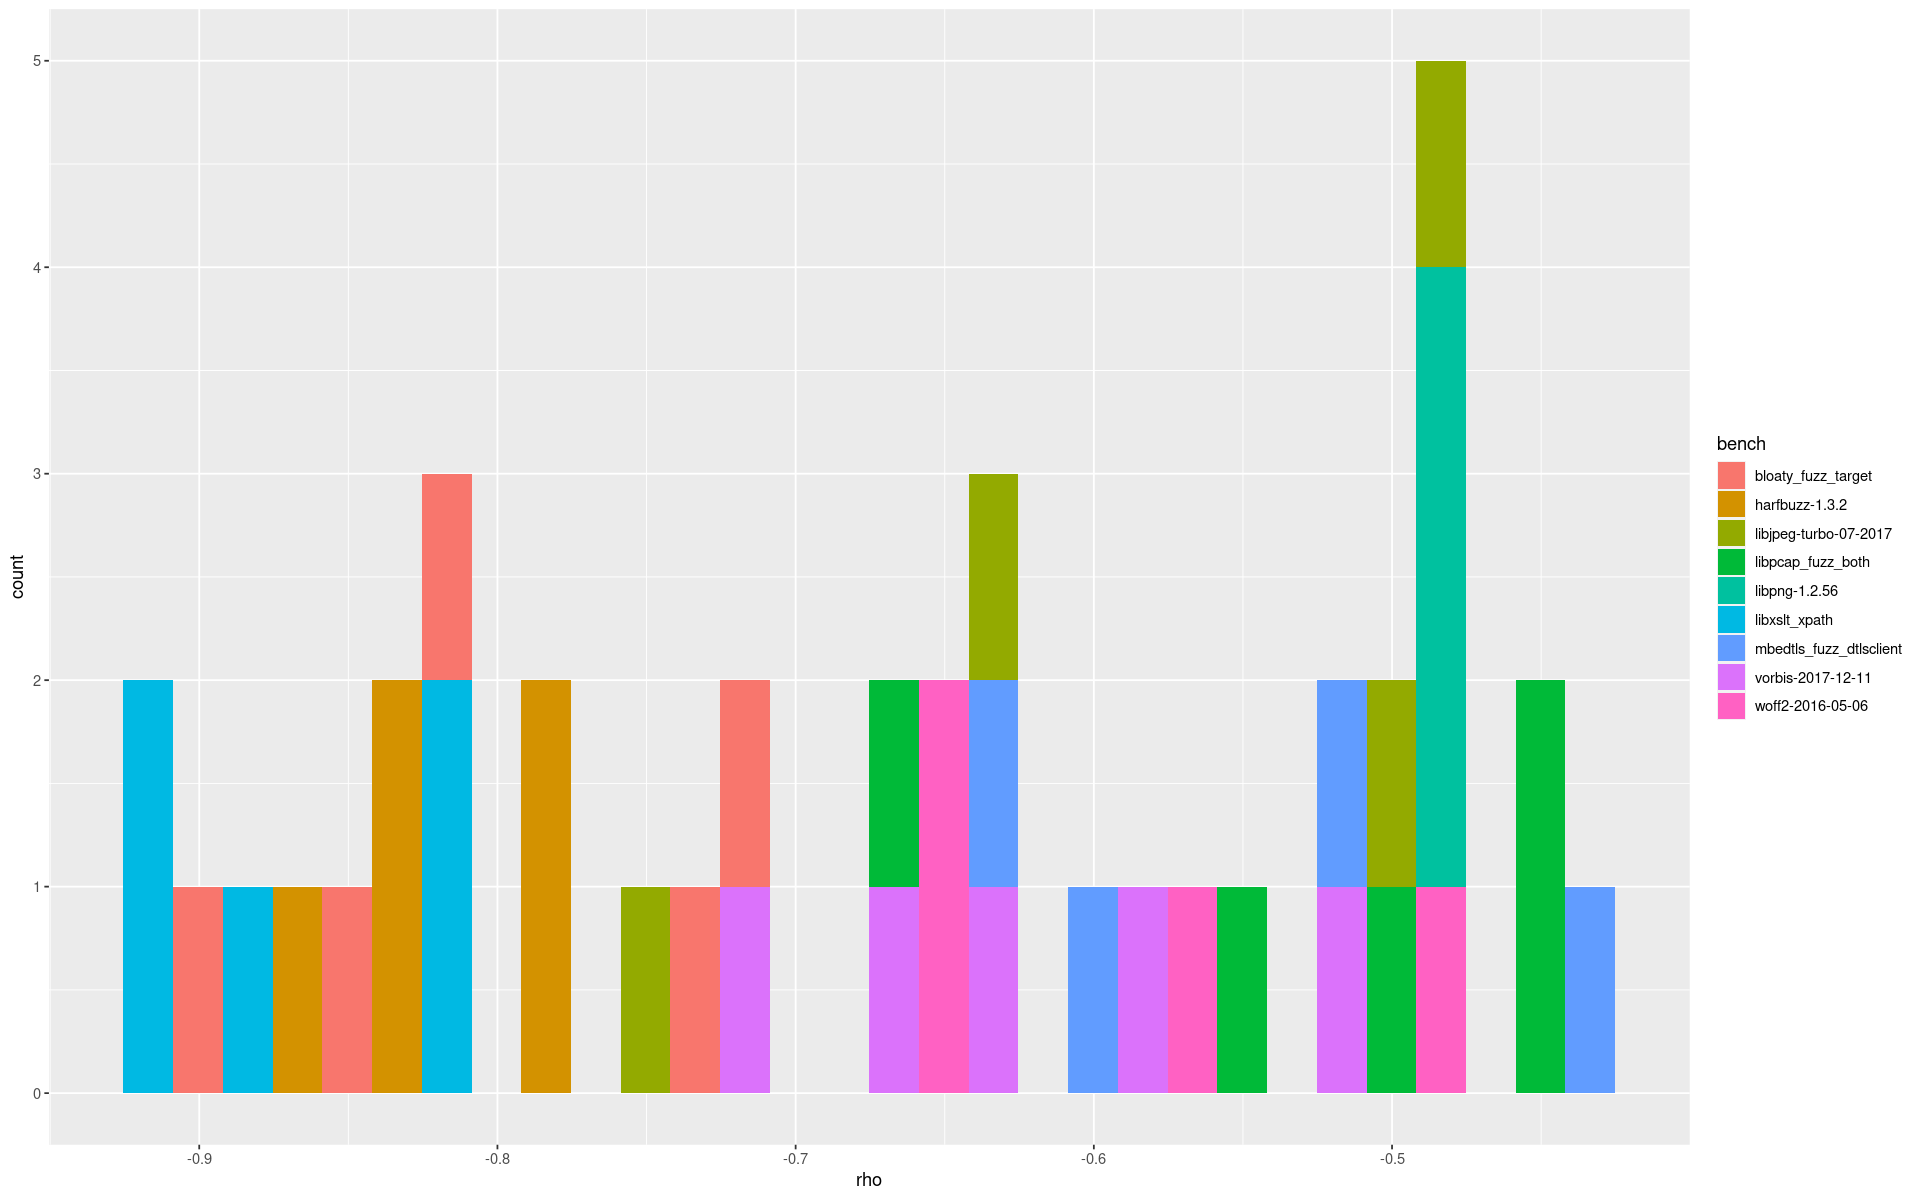

Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”


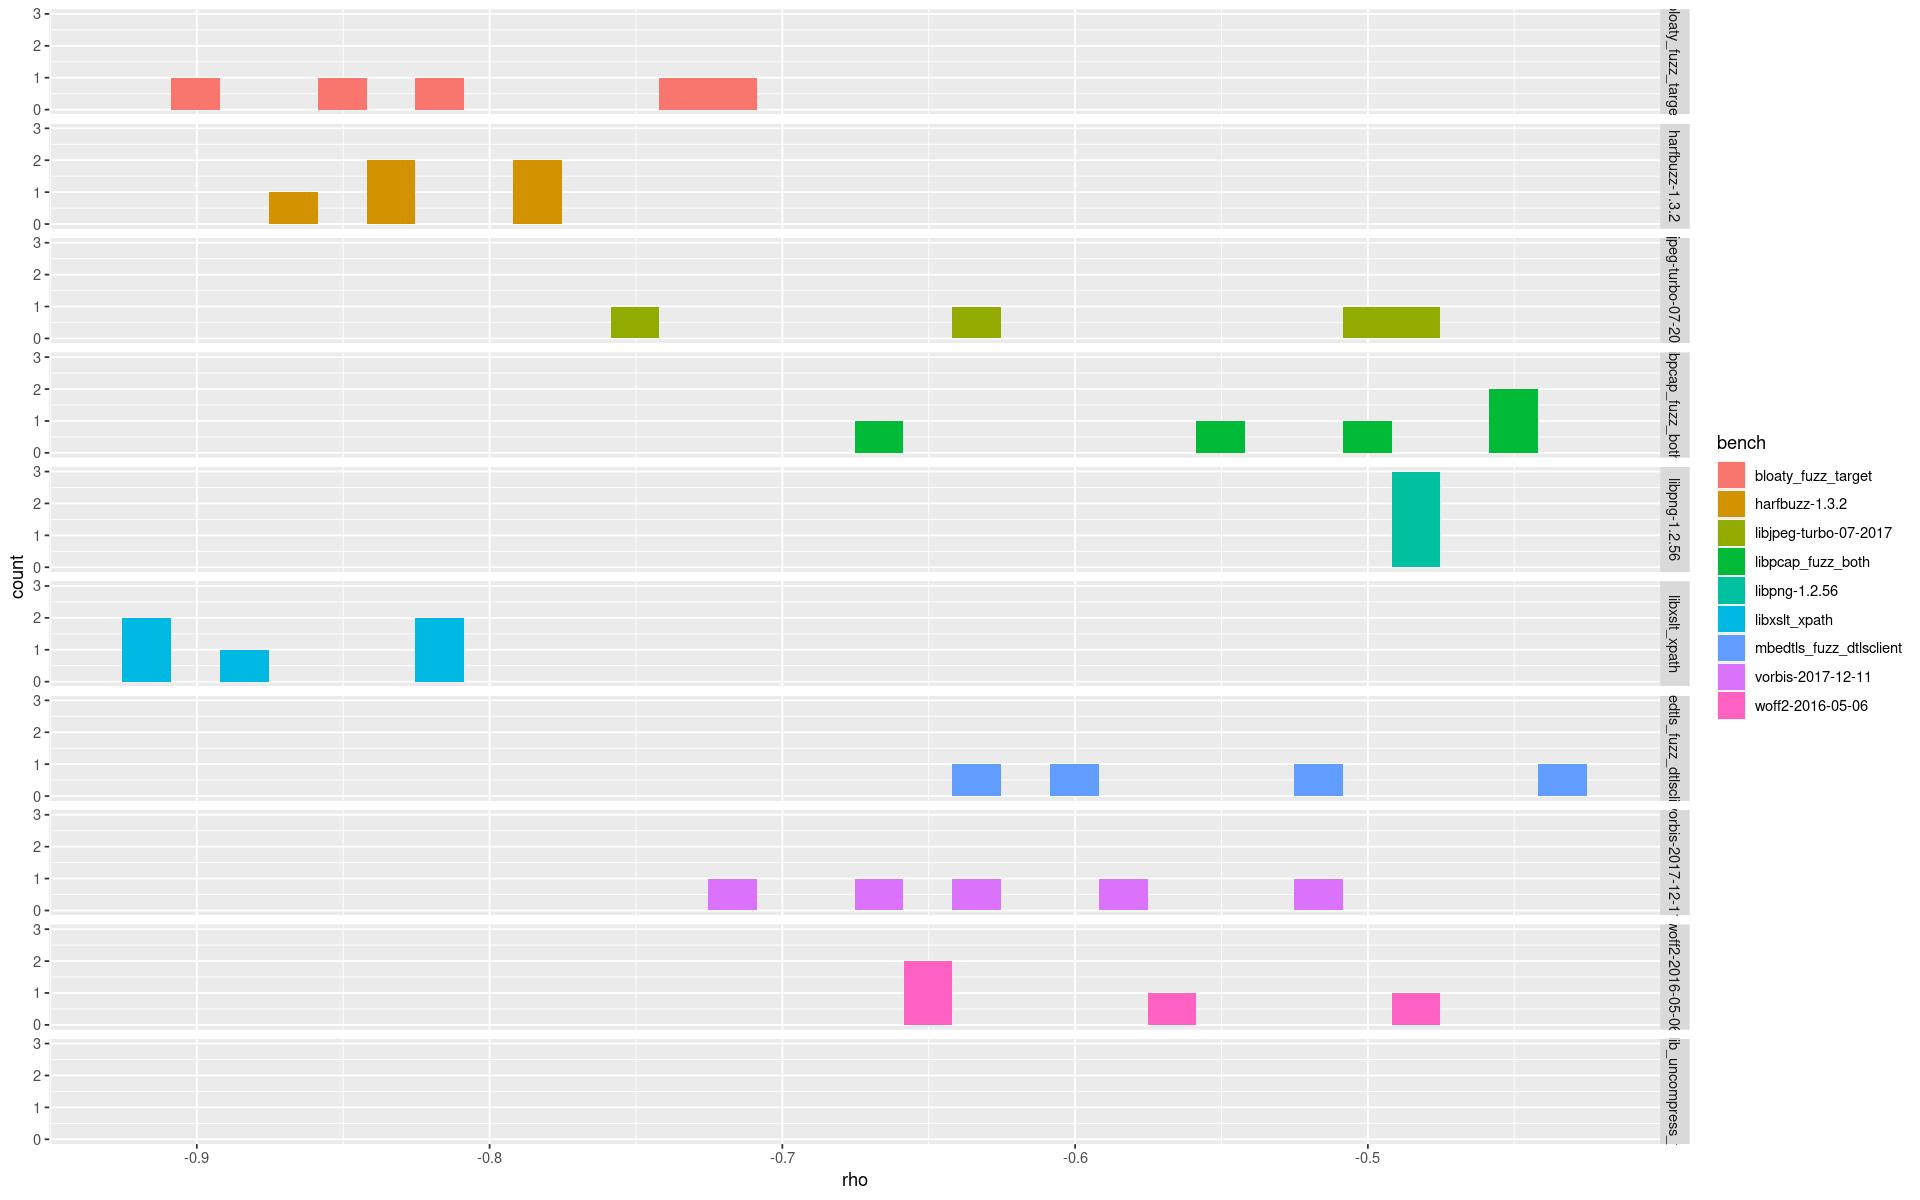

Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”


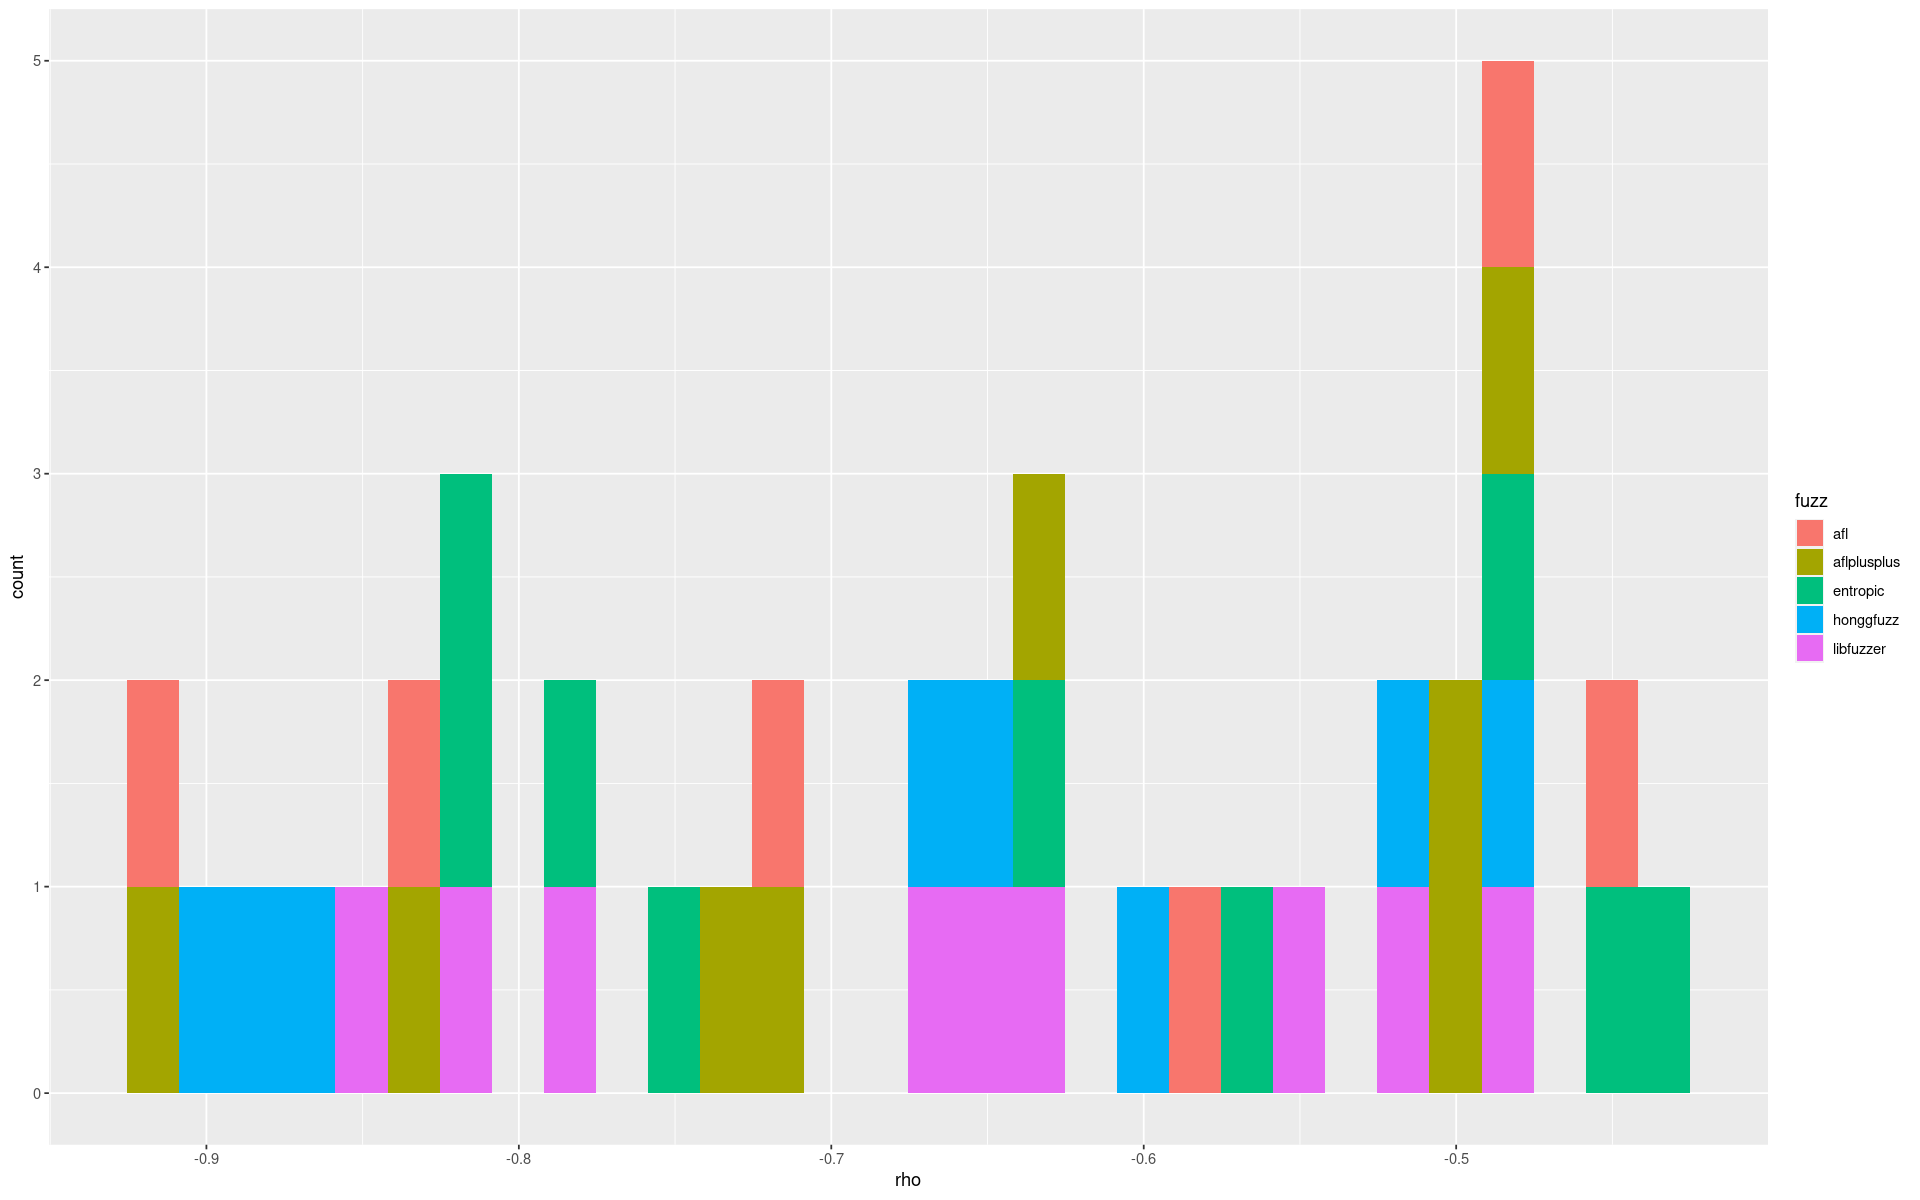

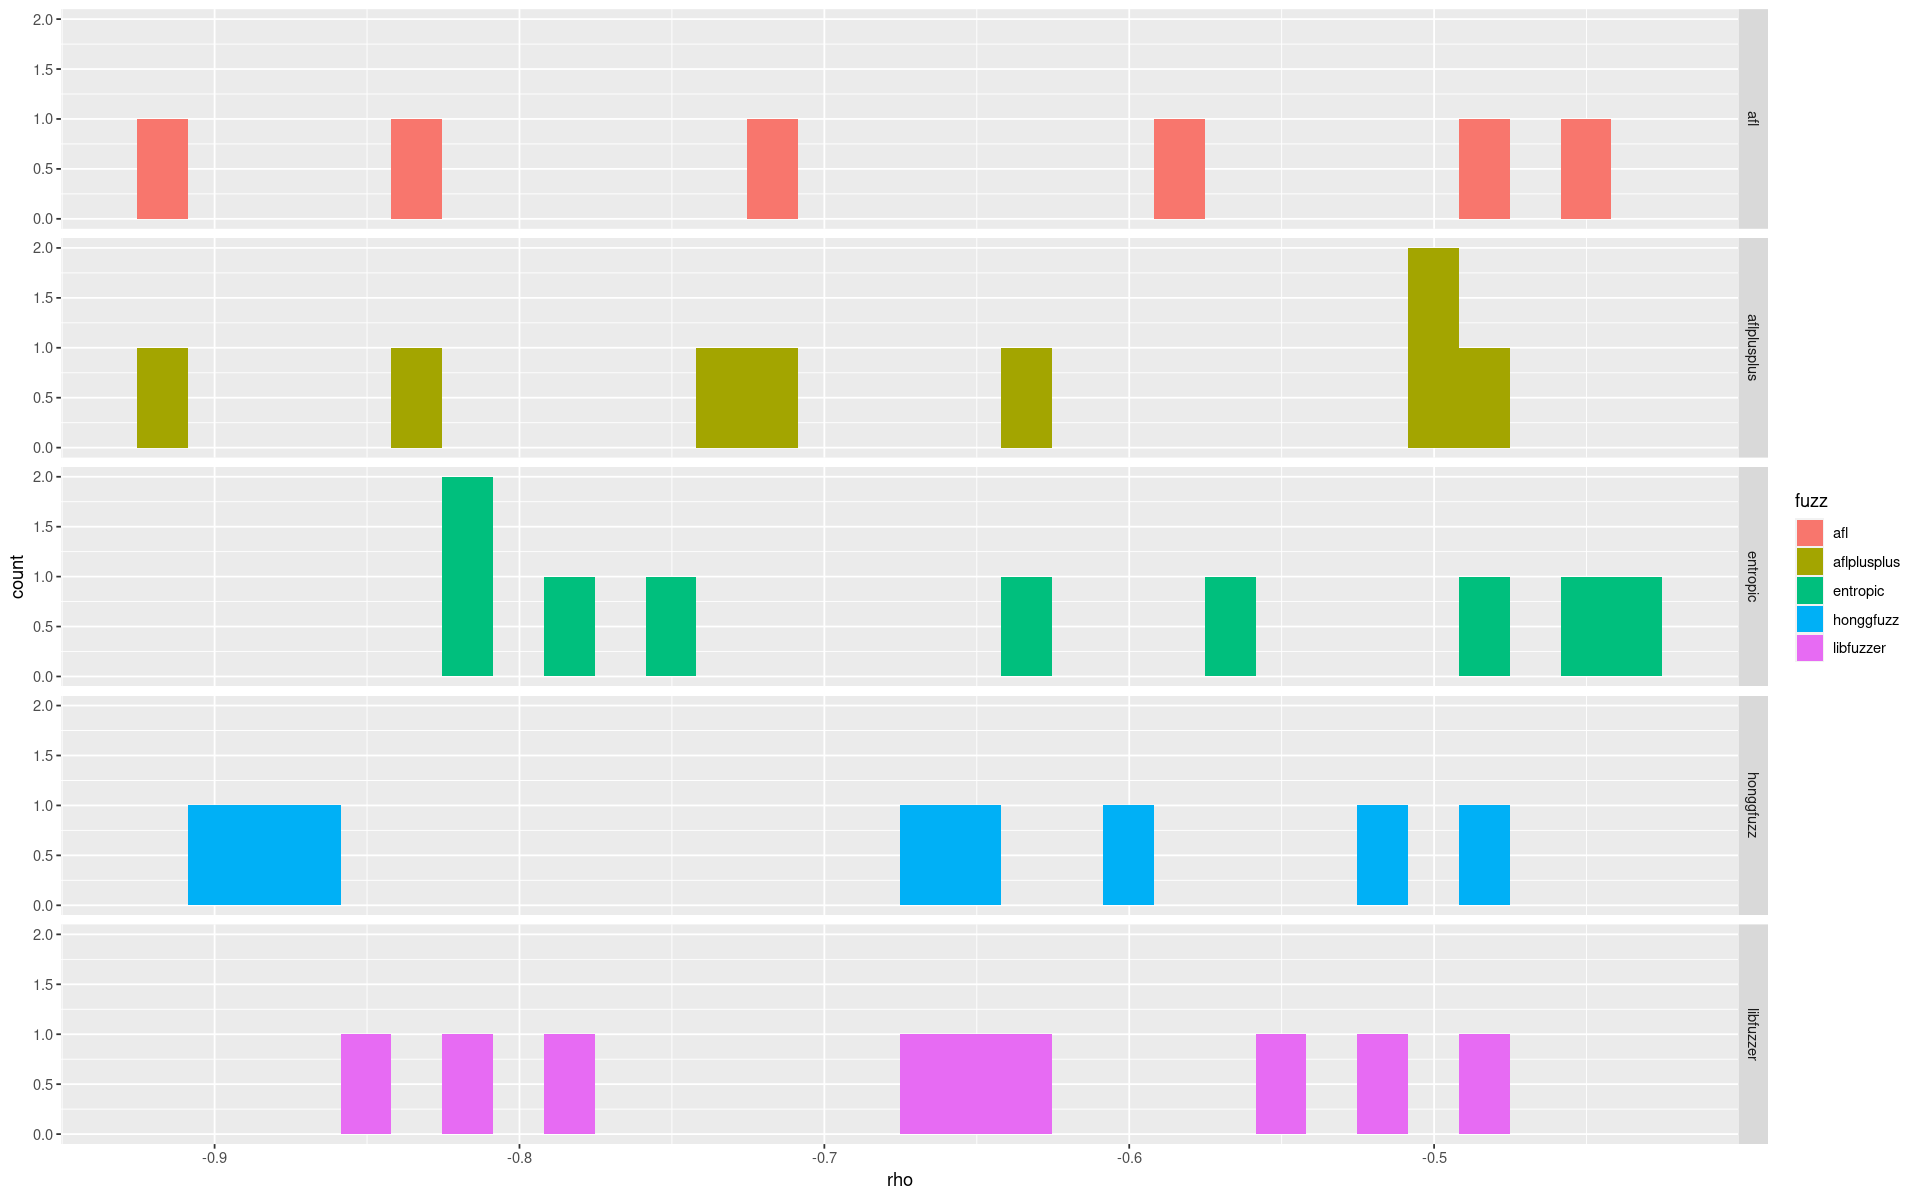

In [134]:
ggp <- ggplot(res, aes(rho, fill = bench)) + geom_histogram(bins=30)
ggp 
ggp + facet_grid(bench ~ .) 
ggp2 <- ggplot(res, aes(rho, fill = fuzz)) + geom_histogram(bins=30)
ggp2
ggp2 + facet_grid(fuzz ~ .) 

In [11]:
library(lme4)
model <- glmer(formula = coverage_inc ~ benchmark + fuzzer + (1 | mean_size_bytes) +
              (1 | initial_coverage) + fuzzer*benchmark +
               + (1 | mean_exec_ns), data = rms_d)
model

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Warning message in glmer(formula = coverage_inc ~ benchmark + fuzzer + (1 | mean_size_bytes) + :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”


Linear mixed model fit by REML ['lmerMod']
Formula: coverage_inc ~ benchmark + fuzzer + (1 | mean_size_bytes) + (1 |  
    initial_coverage) + fuzzer * benchmark + +(1 | mean_exec_ns)
   Data: rms_d
REML criterion at convergence: 15860.74
Random effects:
 Groups           Name        Std.Dev.
 initial_coverage (Intercept) 153.2   
 mean_exec_ns     (Intercept) 147.7   
 mean_size_bytes  (Intercept) 315.5   
 Residual                     167.1   
Number of obs: 1189, groups:  
initial_coverage, 335; mean_exec_ns, 238; mean_size_bytes, 236
Fixed Effects:
                                           (Intercept)  
                                               923.554  
                               benchmarkharfbuzz-1.3.2  
                                               941.571  
                        benchmarklibjpeg-turbo-07-2017  
                                              -403.358  
                            benchmarklibpcap_fuzz_both  
                                          

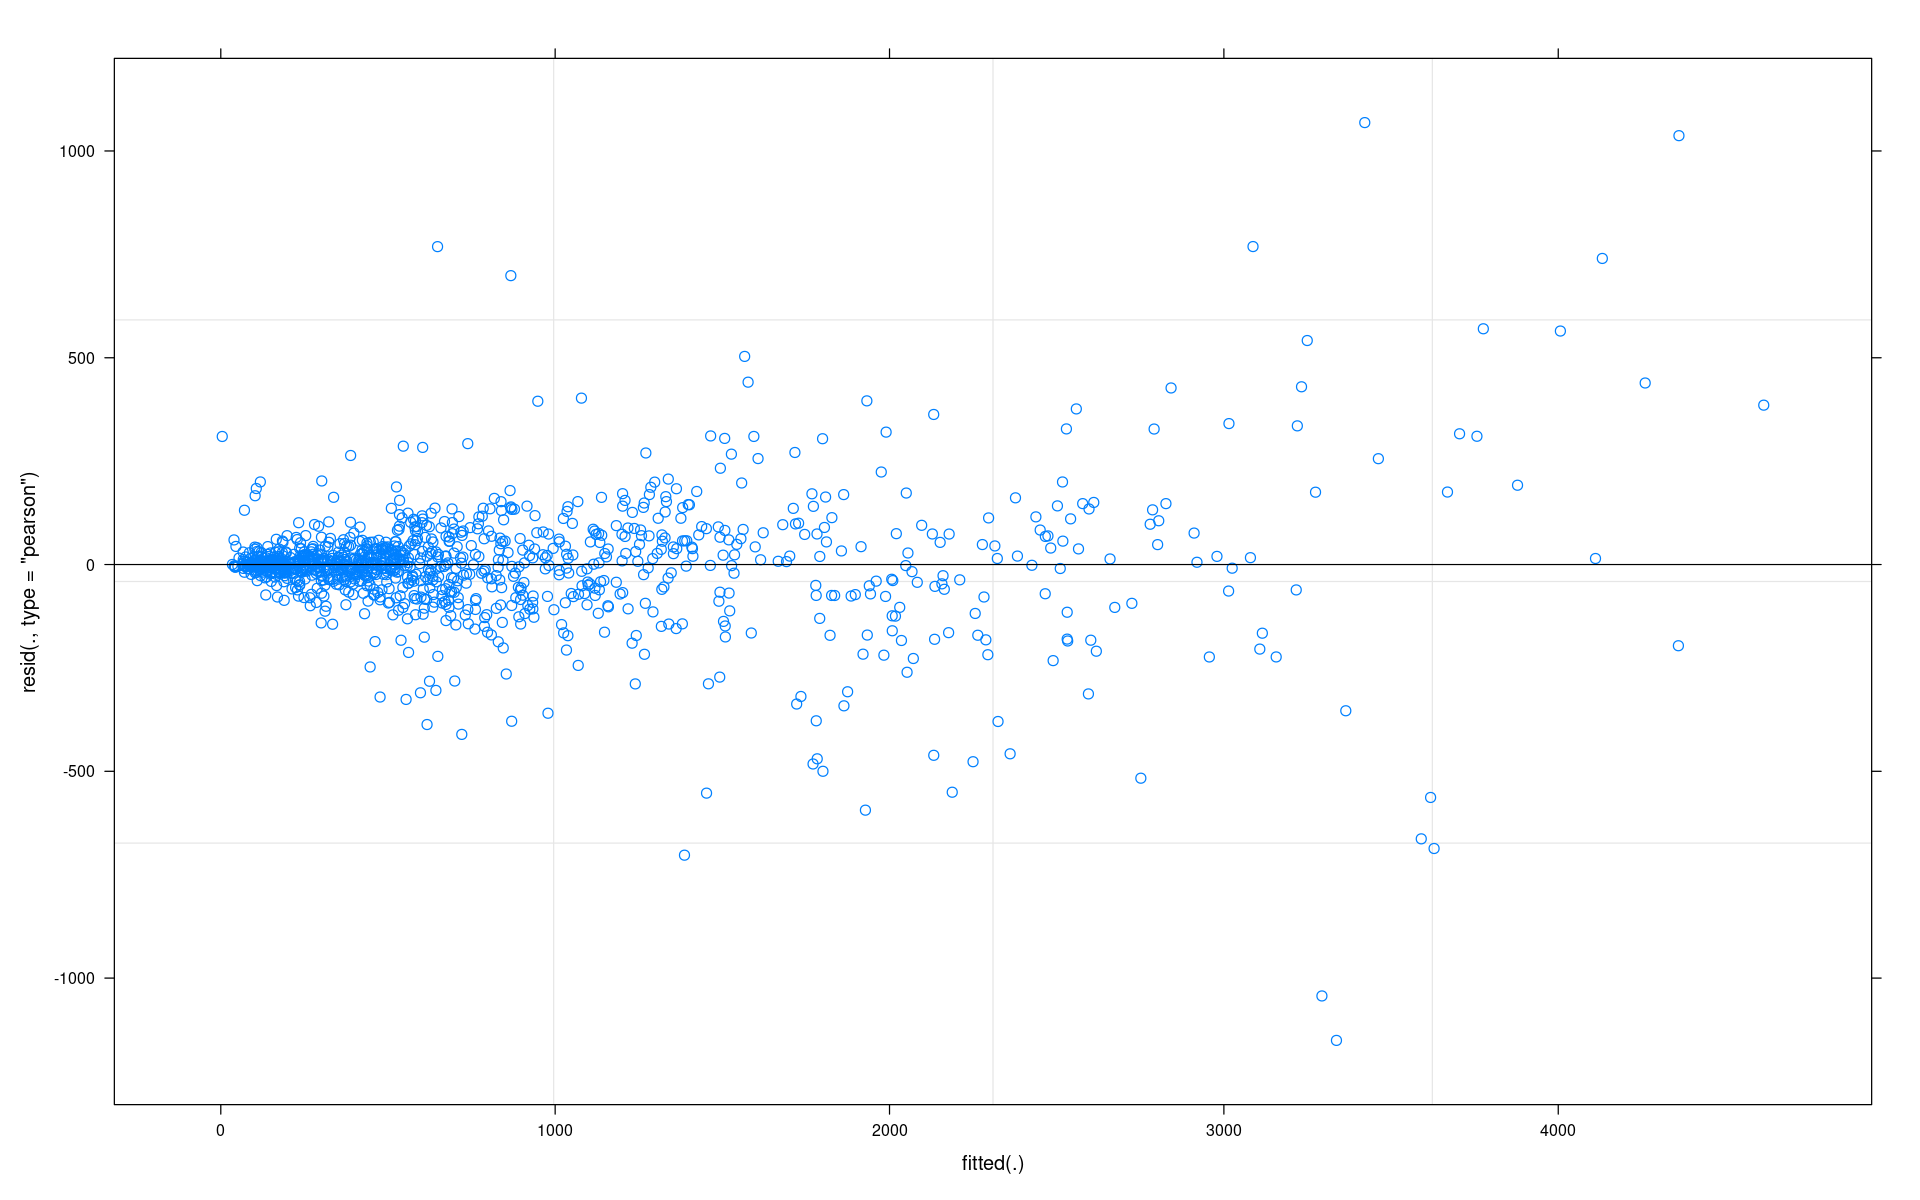

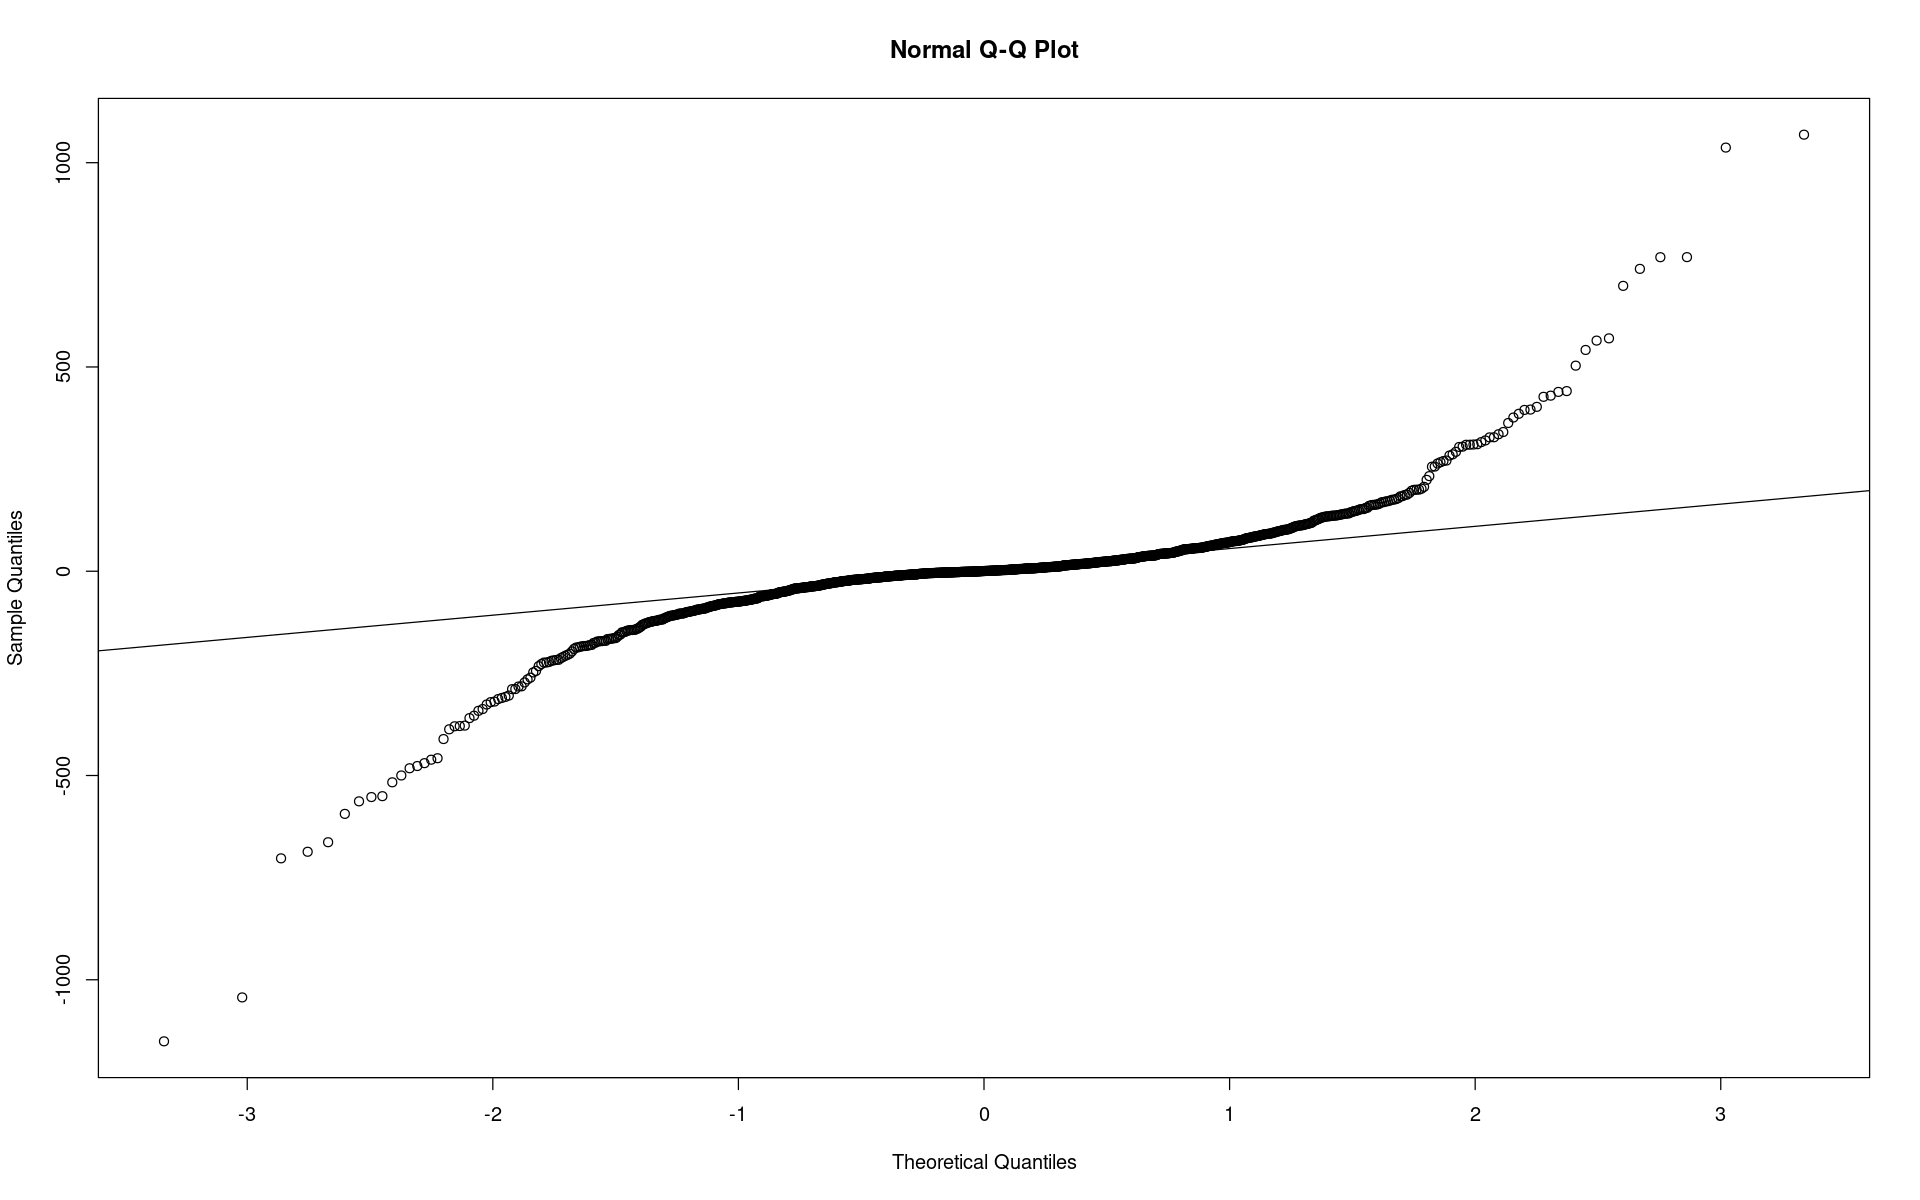

In [12]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))

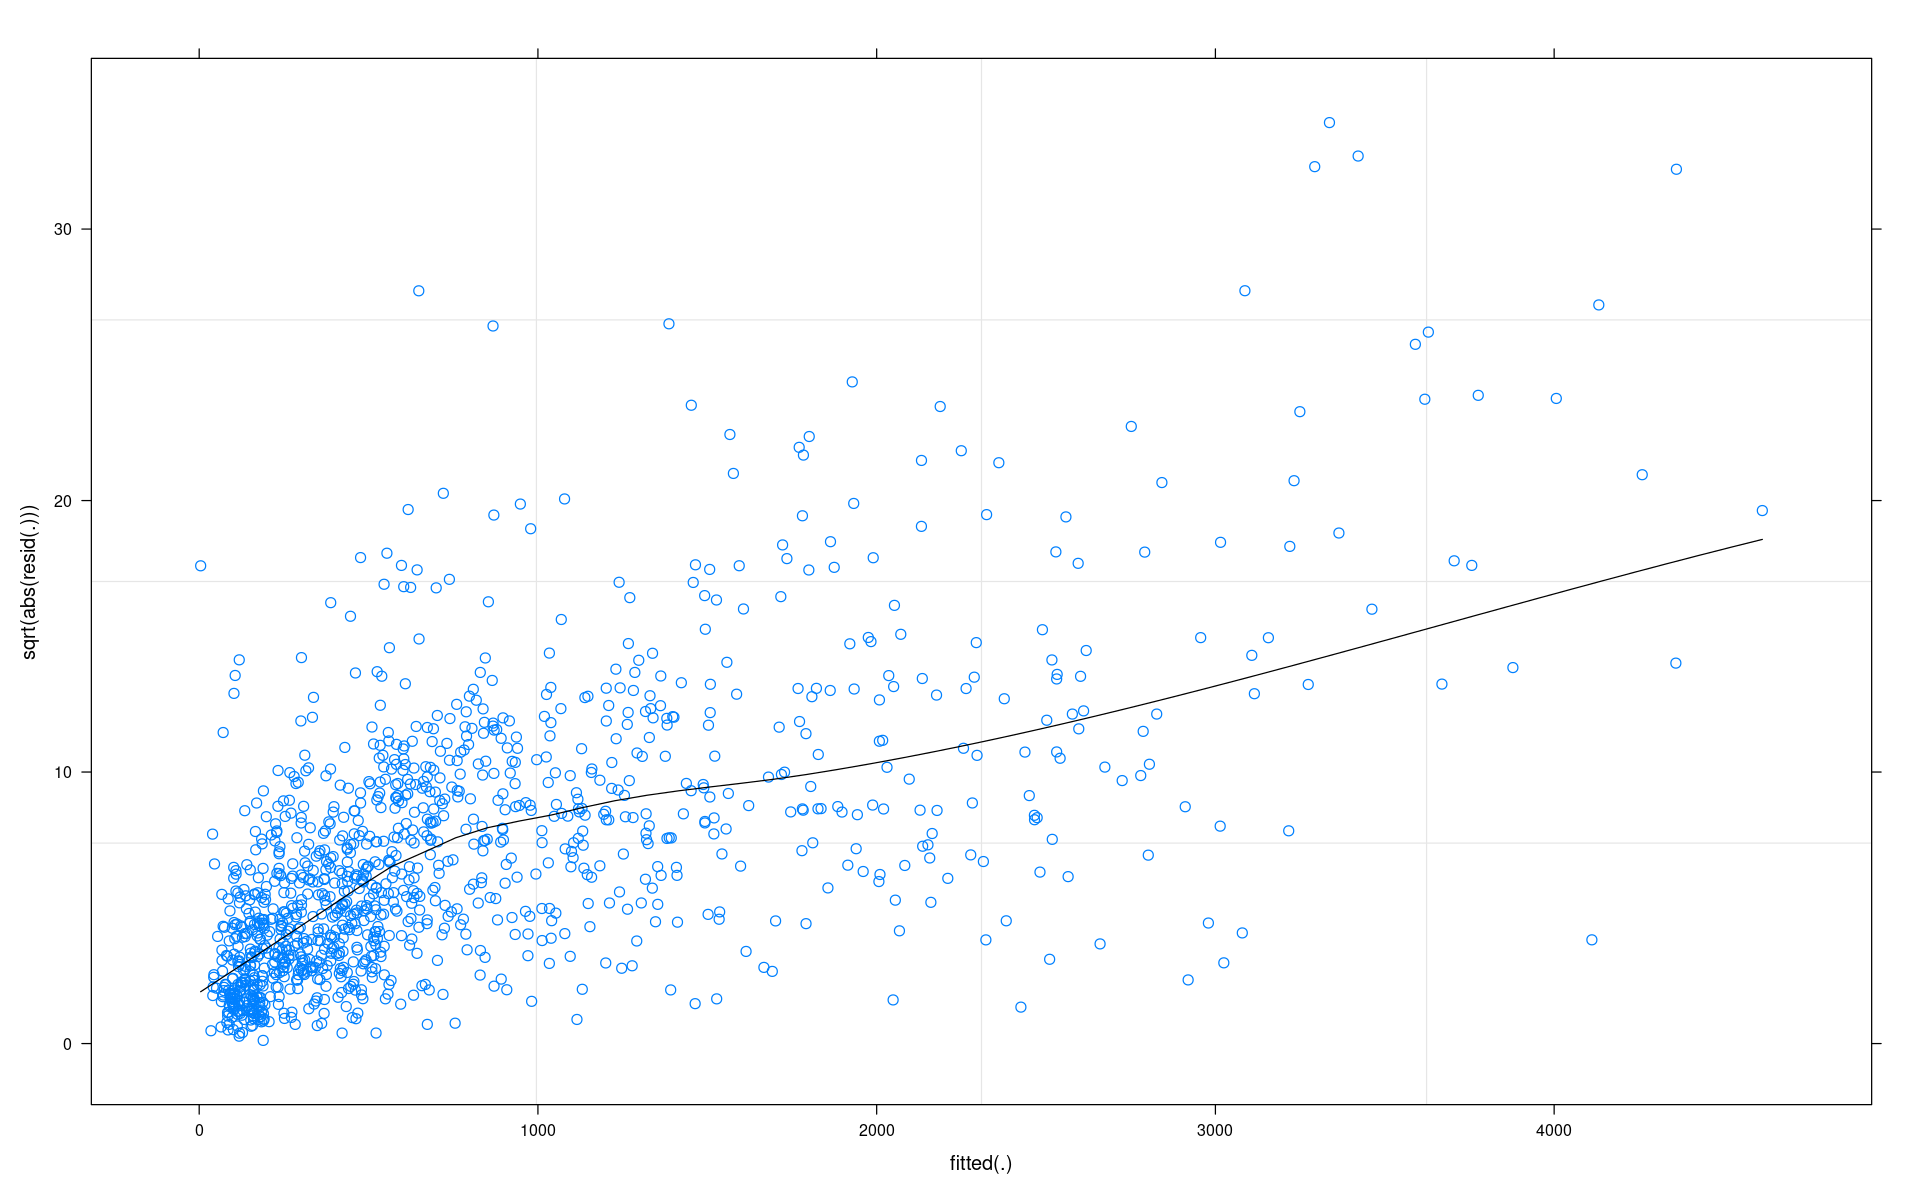

In [13]:
plot(model,
     sqrt(abs(resid(.)))~fitted(.),
     type=c("p","smooth"), col.line=1)

# Preserving below this point for posterity, ignore

## Old POLR stuff
feed the difference in coverage increase across fuzzers for the same benchmark / initial corpus to POLR

In [14]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

,Estimate,Std. Error,t value,p_value
(Intercept),923.554269,85.20359,10.83938180,0.000000e+00
benchmarkharfbuzz-1.3.2,941.570731,120.23588,7.83102964,4.884981e-15
benchmarklibjpeg-turbo-07-2017,-403.357502,120.42969,-3.34931954,8.101031e-04
benchmarklibpcap_fuzz_both,-9.725983,119.23417,-0.08157043,9.349883e-01
benchmarklibpng-1.2.56,-604.887602,120.23588,-5.03084111,4.883327e-07
benchmarklibxslt_xpath,221.933576,119.79919,1.85254660,6.394737e-02
benchmarkmbedtls_fuzz_dtlsclient,-535.766180,119.34873,-4.48908168,7.153087e-06
benchmarkvorbis-2017-12-11,-721.744885,120.20992,-6.00403757,1.924701e-09
benchmarkwoff2-2016-05-06,-681.034618,119.44628,-5.70159738,1.186899e-08
benchmarkzlib_zlib_uncompress_fuzzer,-786.945573,121.53016,-6.47531083,9.461698e-11


ERROR: Error in coefficients[, "Value"]: subscript out of bounds



# POLR on Overall rank across fuzzers and benchmarks


In [ ]:
d <- d %>% filter(benchmark == "harfbuzz-1.3.2" | benchmark == "lcms-2017-03-21")
model <- polr(formula = cif ~ mean.seed.size + initial_coverage + number.of.seeds + experiment + fuzzer + benchmark, data = d)

# Goodness of fit... NULL hypothesis is that data adheres to particular model / distribution
# i.e. p < 0.05  ==>  reject NULL hypothesis, poor fit 
generalhoslem::lipsitz.test(model, g=4)
pulkrob.chisq(model, c("experiment", "fuzzer", "benchmark"))
pulkrob.deviance(model, c("experiment", "fuzzer", "benchmark"))
logitgof(d$cif, fitted(model), ord = TRUE)

# Check proportional odds assumption
brant::brant(model)

In [ ]:
model

In [ ]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

In [ ]:

model <- polr(formula = cov_inc_rank ~ number.of.seeds*fuzzer + mean.seed.size*fuzzer + initial_coverage*fuzzer + experiment*fuzzer + benchmark*fuzzer + fuzzer, data = d)

# Goodness of fit... NULL hypothesis is that data adheres to particular model / distribution
# i.e. p < 0.05  ==>  poor fit 
generalhoslem::lipsitz.test(model)
pulkrob.chisq(model, c("experiment", "fuzzer", "benchmark"))
pulkrob.deviance(model, c("experiment", "fuzzer", "benchmark"))
logitgof(d$cov_inc_rank, fitted(model), ord = TRUE)
brant::brant(model)

In [ ]:
model
simple <- polr(formula = cov_inc_rank ~ benchmark*fuzzer + fuzzer, data = d)
simple

In [ ]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

In [ ]:
# install.packages("mctest")

library(mctest)

mctest::omcdiag(mod = model)

In [ ]:
orm(formula = cdif ~ mean.seed.size + initial_coverage + number.of.seeds + experiment, data = M)

In [ ]:
# Rank ANCOVA

d$mssf <- factor(d$mean.seed.size, ordered=TRUE)
d$nosf <- factor(d$number.of.seeds, ordered=TRUE)
d$icf <- factor(d$initial_coverage, ordered=TRUE)
d

https://influentialpoints.com/Training/nonparametric_multiple_comparisons.html
tukey test analogy, Nemenyi joint rank test.dunn test for bonferonni correct